Graphs and Charts
========================
This notebook looks at some of the tools for building graphical visualizations of our data, as well as some new, useful techniques for transforming data to help with the data viz.

Topics covered:

- `DataFrame.melt()` the "unpivot" method that helps transform data from "wide" to "long" format
- `DataFrame.drop_duplicates()` to remove duplicate rows
- calculating correlations on all factors
- heatmap table of correlations
- using `zscore` to drop outliers
- controlling size, color, other attributes of `matplotlib` images
- simple bar charts
- grouped bar charts
- scatter plots
- network (node/edge) diagrams
- our custom helper functions, `ui.fmt_table()`
- new `school_data` package for custom code

The data for these examples comes from the combined demographic and grades 3-8 ELA test score data set.

In [1]:
# automatically reload changes we make to schools.py and ui.py
%load_ext autoreload
%autoreload 2

# load the demographic data
import pandas as pd

import numpy as np
import scipy as scipy
from scipy.stats import pearsonr
import statsmodels.api as sm
import pingouin as pg
from statsmodels.formula.api import ols

from sklearn.linear_model import LinearRegression
from sklearn.model_selection import train_test_split
from sklearn.metrics import mean_squared_error, r2_score
from sklearn.preprocessing import scale 
from sklearn.cross_decomposition import PLSRegression


# graphs and viz
import matplotlib.pyplot as plt
import seaborn as sns
import networkx as nx


import math

from IPython.display import Markdown as md

from school_data import schools, ui, exams


In [2]:
# load the demographic data and merge it with the math data
df = schools.load_school_demographics()

math_df = exams.load_math()

math_df = df.merge(math_df, how="inner", on=["dbn", "ay"])
math_df = math_df[math_df["mean_scale_score"].notnull()]

Predicting test scores
-------------------------------


In [3]:
# use the ela data frame that we loaded at the top

# get just the 2019 test results for All Students
# this will be the dependent variable in our regression
data = math_df.query(f"ay == {math_df.ay.max()} and category == 'All Students'")
# calculate coefficients for these factors
factors = ['total_enrollment', 'asian_pct','black_pct', 
       'hispanic_pct',  'white_pct','swd_pct', 'ell_pct',  'poverty_pct', 'charter']

data = data[["mean_scale_score"] + factors]
data.charter = data.charter.apply(lambda x: 1 if x else 0)
corr = data.corr().sort_values(by="mean_scale_score")
corr.style.background_gradient(cmap=plt.cm.coolwarm)
corr

,mean_scale_score,total_enrollment,asian_pct,black_pct,hispanic_pct,white_pct,swd_pct,ell_pct,poverty_pct,charter
poverty_pct,-0.555660,-0.160478,-0.260532,0.315965,0.490648,-0.814028,0.321996,0.410576,1.000000,0.093889
swd_pct,-0.549075,-0.365178,-0.349036,0.109240,0.266018,-0.177316,1.000000,0.042266,0.321996,-0.259609
hispanic_pct,-0.343126,-0.072222,-0.330903,-0.419660,1.000000,-0.380352,0.266018,0.526813,0.490648,-0.051718
ell_pct,-0.268894,0.092477,0.189464,-0.423749,0.526813,-0.215471,0.042266,1.000000,0.410576,-0.236553
black_pct,-0.240674,-0.286883,-0.455616,1.000000,-0.419660,-0.475151,0.109240,-0.423749,0.315965,0.336198
total_enrollment,0.293220,1.000000,0.363721,-0.286883,-0.072222,0.185958,-0.365178,0.092477,-0.160478,0.003416
charter,0.297497,0.003416,-0.230401,0.336198,-0.051718,-0.203052,-0.259609,-0.236553,0.093889,1.000000
asian_pct,0.388405,0.363721,1.000000,-0.455616,-0.330903,0.182161,-0.349036,0.189464,-0.260532,-0.230401
white_pct,0.423330,0.185958,0.182161,-0.475151,-0.380352,1.000000,-0.177316,-0.215471,-0.814028,-0.203052
mean_scale_score,1.000000,0.293220,0.388405,-0.240674,-0.343126,0.423330,-0.549075,-0.268894,-0.555660,0.297497


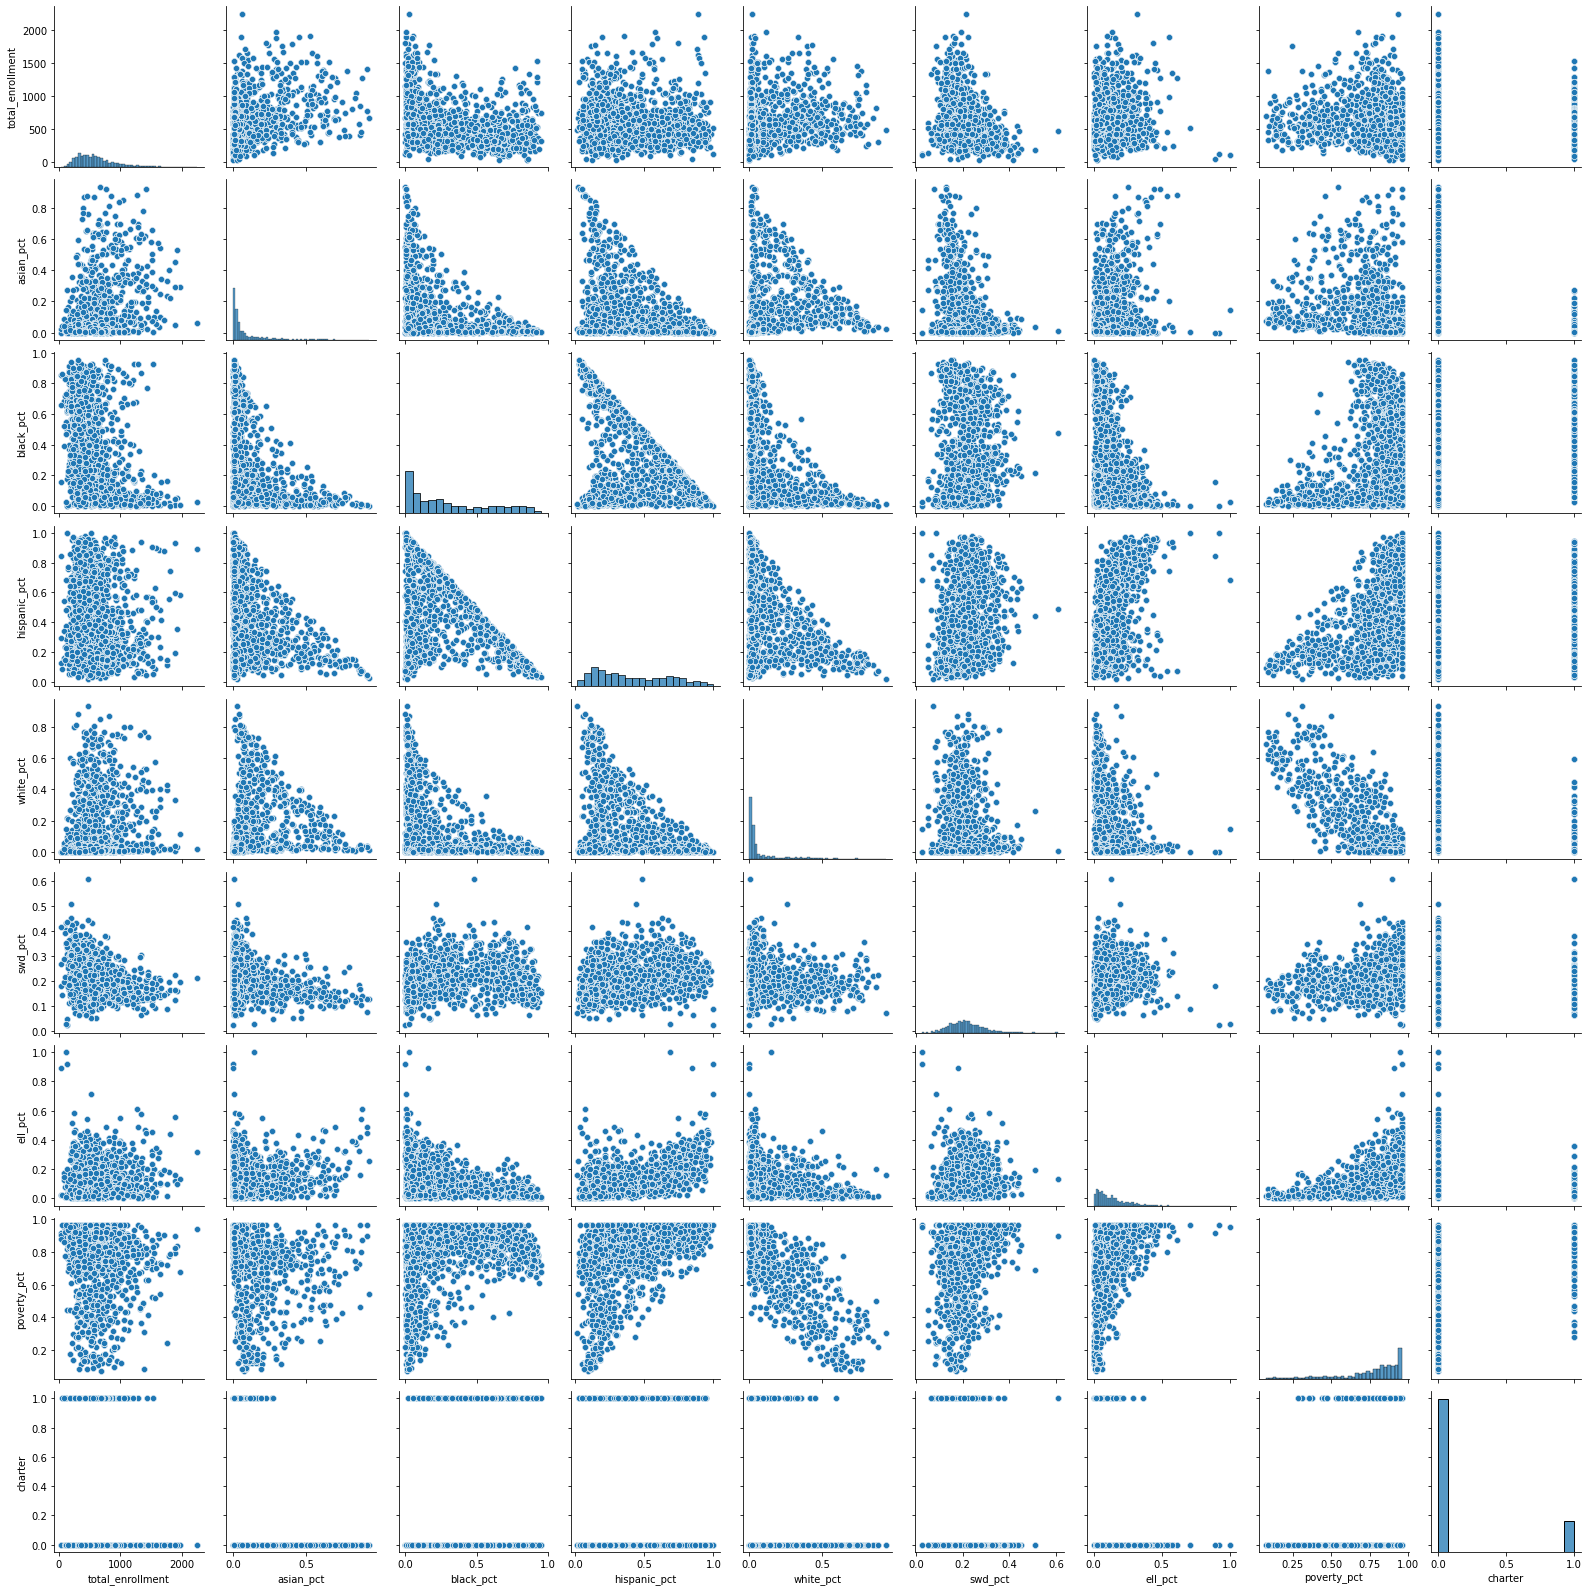

In [4]:
sns.pairplot(data[factors])
plt.show()

In [5]:
model = LinearRegression()

# get all students for the most recent year
data = math_df.query(f"ay == {math_df.ay.max()} and category == 'All Students'")


In [6]:
# calculate coefficients for these factors
factors = ['total_enrollment', 'asian_pct','black_pct', 
       'hispanic_pct',  'white_pct','swd_pct', 'ell_pct',  'poverty_pct', 'charter']
X = data[factors]
y = data['mean_scale_score']
X_train, X_test, y_train, y_test = train_test_split(X, y, shuffle=True, train_size=0.3)

model.fit(X_train, y_train)
predictions = model.predict(X_test)
r2 = r2_score(y_test, predictions)
rmse = mean_squared_error(y_test, predictions, squared=False)
print('The r2 is: ', r2)
print('The rmse is: ', rmse)
# list(zip(model.feature_names_in_, model.coef_))

The r2 is:  0.5971840129429672
The rmse is:  7.2320469520044295


In [7]:
# calculate coefficients for these factors
factors = ['total_enrollment', 'asian_pct','black_pct', 
       'hispanic_pct',  'white_pct','swd_pct', 'ell_pct','poverty_pct',  'eni_pct', 'charter']

X = data[factors]
y = data['mean_scale_score']
X_train, X_test, y_train, y_test = train_test_split(X, y, shuffle=True, train_size=0.3)

model.fit(X_train, y_train)
predictions = model.predict(X_test)
r2 = r2_score(y_test, predictions)
rmse = mean_squared_error(y_test, predictions, squared=False)
print('The r2 is: ', r2)
print('The rmse is: ', rmse)

The r2 is:  0.5972611260836276
The rmse is:  7.129242158590545


In [19]:
# add school district
factors = ['asian_pct', 'black_pct',  'hispanic_pct',  'white_pct',
           'swd_pct', 'ell_pct','poverty_pct',  'eni_pct', 'charter']

X = data[factors]
y = data['mean_scale_score']
X_train, X_test, y_train, y_test = train_test_split(X, y, shuffle=True, train_size=0.3)


model.fit(X_train, y_train)
predictions = model.predict(X_test)
r2 = r2_score(y_test, predictions)
rmse = mean_squared_error(y_test, predictions, squared=False)
print('The r2 is: ', r2)
print('The rmse is: ', rmse)
list(zip(factors,model.coef_))

The r2 is:  0.6045034464102292
The rmse is:  7.084227220169989


[('asian_pct', 33.46462025996787),
 ('black_pct', 9.896314895686578),
 ('hispanic_pct', 16.190578557473508),
 ('white_pct', 19.062110872079455),
 ('swd_pct', -40.27307842958005),
 ('ell_pct', -18.506083764535436),
 ('poverty_pct', -8.188624575567891),
 ('eni_pct', -8.654208533482123),
 ('charter', 10.313821455329352)]

Partial Least Squares
===================

In [41]:
from sklearn.preprocessing import scale 
from sklearn import model_selection
from sklearn.model_selection import RepeatedKFold
from sklearn.model_selection import train_test_split
from sklearn.cross_decomposition import PLSRegression
from sklearn.metrics import mean_squared_error

X_train, X_test, y_train, y_test = train_test_split(X, y, shuffle=True, train_size=0.3)

pls = PLSRegression(n_components=len(factors))
pls.fit(X_train, y_train)

# r2 = r2_score(y_test, predictions)
# np.sqrt(mean_squared_error(y_test, pls.predict(scale(X_test))))
predictions = pls.predict(X_test)
r2 = r2_score(y_test, predictions)
rmse = mean_squared_error(y_test, predictions, squared=False)
print('The r2 is: ', r2)
print('The rmse is: ', rmse)
list(zip(factors,pls.coef_))

The r2 is:  0.6001230833313622
The rmse is:  7.177815485843485


[('asian_pct', array([3.44575417])),
 ('black_pct', array([-1.01064704])),
 ('hispanic_pct', array([1.03193842])),
 ('white_pct', array([1.36719517])),
 ('swd_pct', array([-2.64662041])),
 ('ell_pct', array([-1.82288455])),
 ('poverty_pct', array([-1.41052107])),
 ('eni_pct', array([-1.98249656])),
 ('charter', array([3.83424088]))]

In [43]:
# results = pd.DataFrame(data=np.array([factors, list(pls.coef_), list(model.coef_)]), columns=["factor", "pls-coef", "ols-coef"])
model.fit(X, y)
pls.fit(X, y)


# results
# np.array([factors, list(pls.coef_), list(model.coef_)])
pls_co = [x[0] for x in pls.coef_]
model_co = [x[0] for x in model.coef_]


[3.699225704202494,
 -0.5840545036062242,
 1.339961130179512,
 1.584960383336846,
 -2.6454552371208444,
 -1.8784918845430176,
 -1.3859469497700723,
 -1.9640285970769358,
 3.904369206943734]